In [1]:
require(data.table)
require(cowplot)
require(ggplot2)
require(scattermore)
require(pbapply)
pboptions(type="timer")

Loading required package: data.table

Loading required package: cowplot

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: ggplot2

Loading required package: scattermore

Loading required package: pbapply



In [2]:
root_path = "/mnt/data/Imaging/202105-Deconwolf/data_210726"

In [3]:
dots_data = readRDS(file.path(root_path, "dots_data.rds"))

In [4]:
# Dots with infinite SNR2
dots_data[!is.finite(SNR2), .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,7906
60x,dw,46


In [5]:
# Dots with negative or null SNR2
dots_data[SNR2 <= 0, .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,340947
20x,raw,207777
60x,dw,221
60x,raw,59085


In [6]:
# Dots with negative intensity value
dots_data[Value <= 0, .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,56043


In [7]:
# Dots with finite, positive and non-null SNR2, and with positive and non-null intensity value
dots_data[is.finite(SNR2) & SNR2 > 0 & Value2 > 0, .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,5691673
20x,raw,6792223
60x,dw,6999733
60x,raw,6940915


In [8]:
dots_data2 = dots_data[is.finite(SNR2) & SNR2 > 0 & Value2 > 0]

# Plot SNR vs intensity

### Using all dots

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=44s  


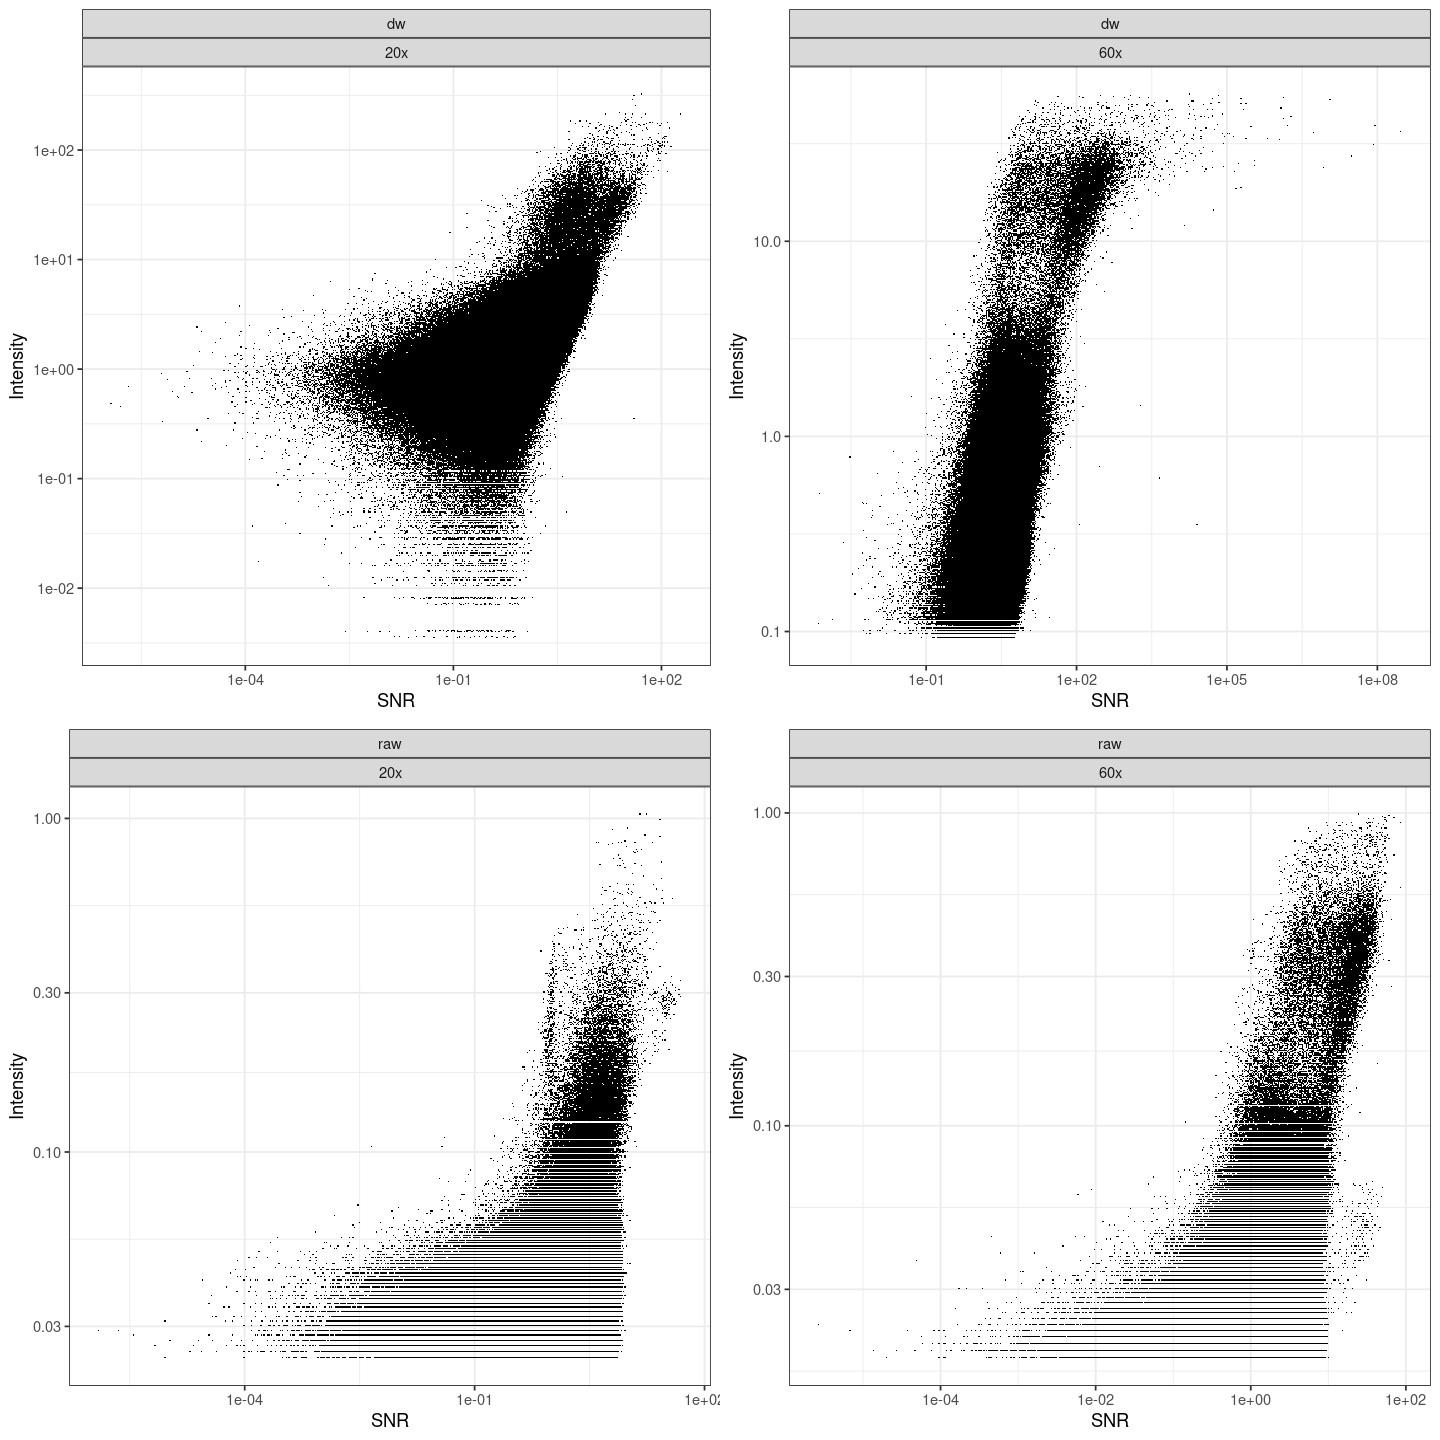

In [9]:
plist = pblapply(split(dots_data2, list(dots_data2$magnification, dots_data2$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            facet_wrap(~image_type~magnification, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=12, repr.plot.height=12)
plot_grid(plotlist=plist, nrow=2)

### After filtering for FWHM in [0.5; 5]

In [10]:
ddata = dots_data2[FWHM >= .5 & FWHM <= 5]
ddata[, .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,3347872
20x,raw,4371727
60x,dw,5312953
60x,raw,4624742


  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=32s  


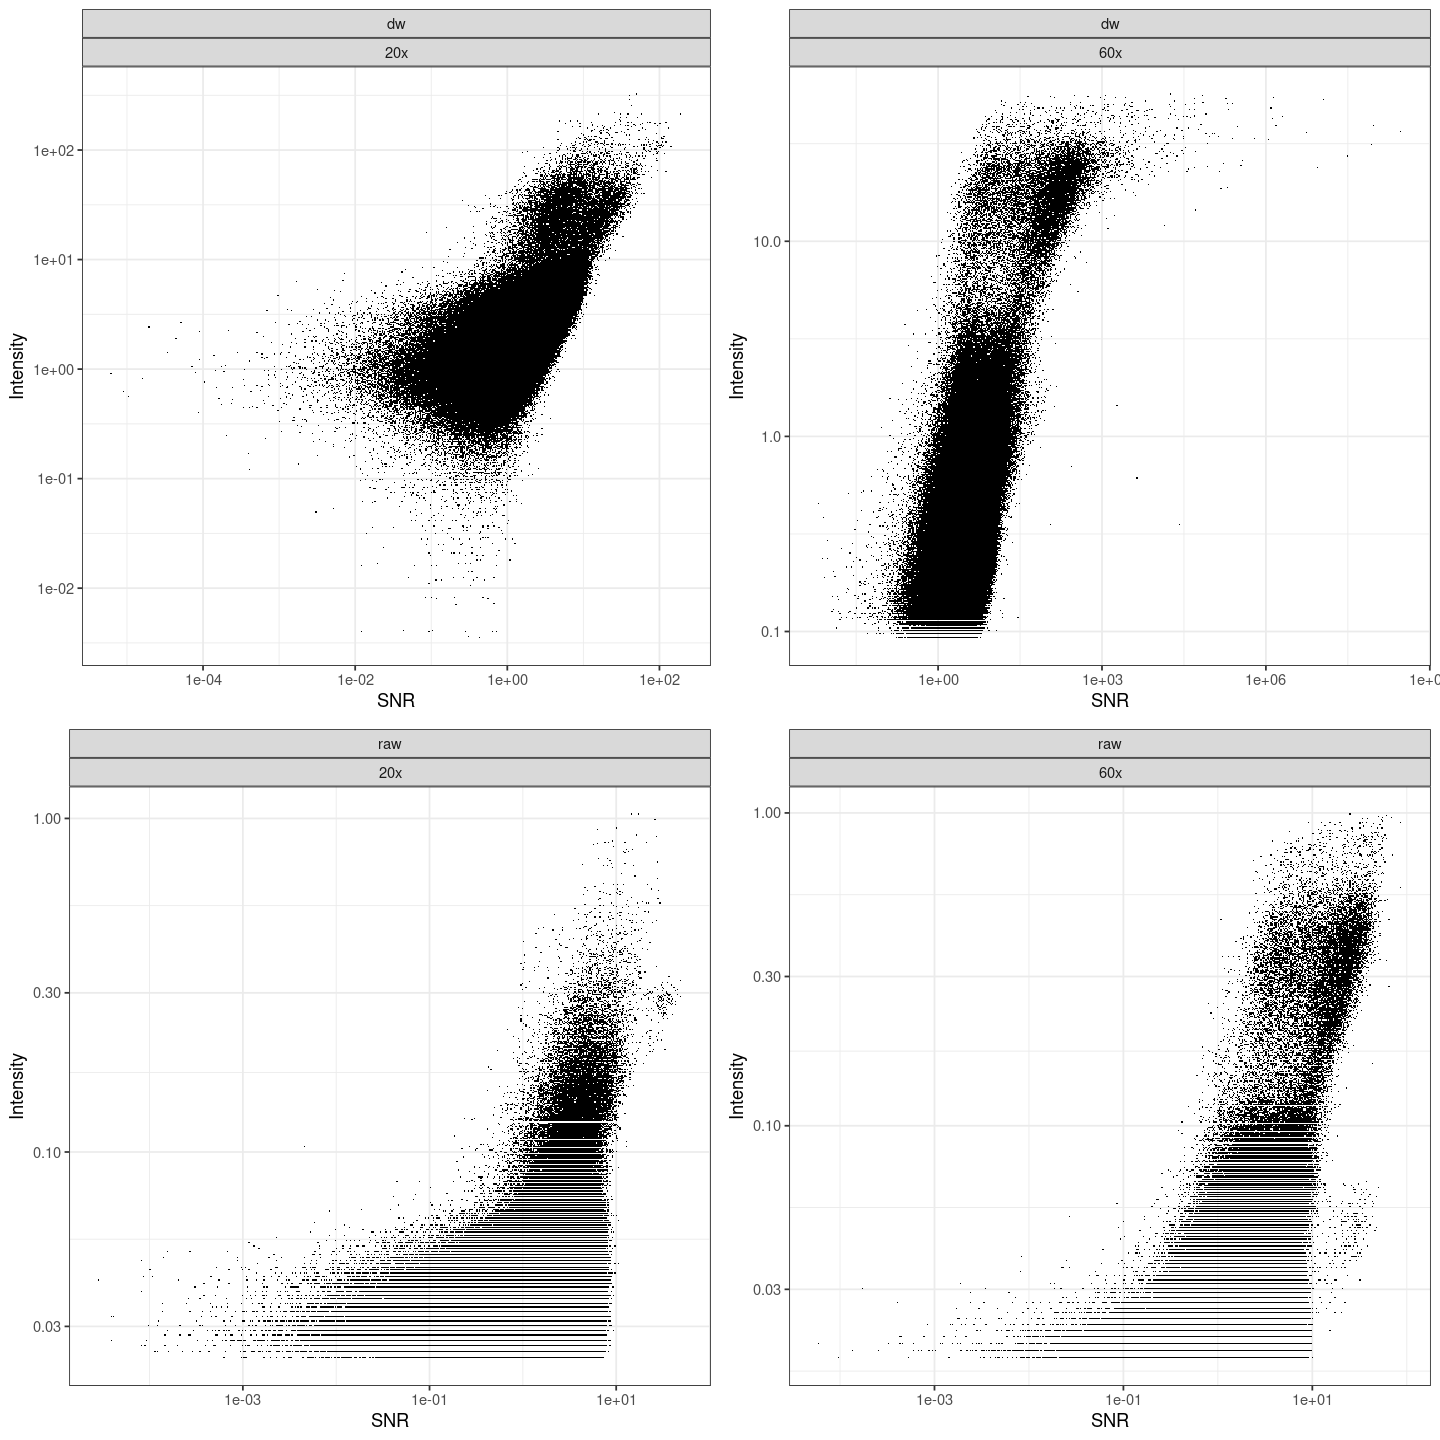

In [11]:
plist = pblapply(split(ddata, list(ddata$magnification, ddata$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            facet_wrap(~image_type~magnification, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=12, repr.plot.height=12)
plot_grid(plotlist=plist, nrow=2)

### After filtering for FWHM in [0.5; 5] and selecting only dots in nuclei

In [12]:
ddata = dots_data2[FWHM >= .5 & FWHM <= 5 & nid > 0]
ddata[, .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,1444904
20x,raw,1954451
60x,dw,2163105
60x,raw,2567803


  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=12s  


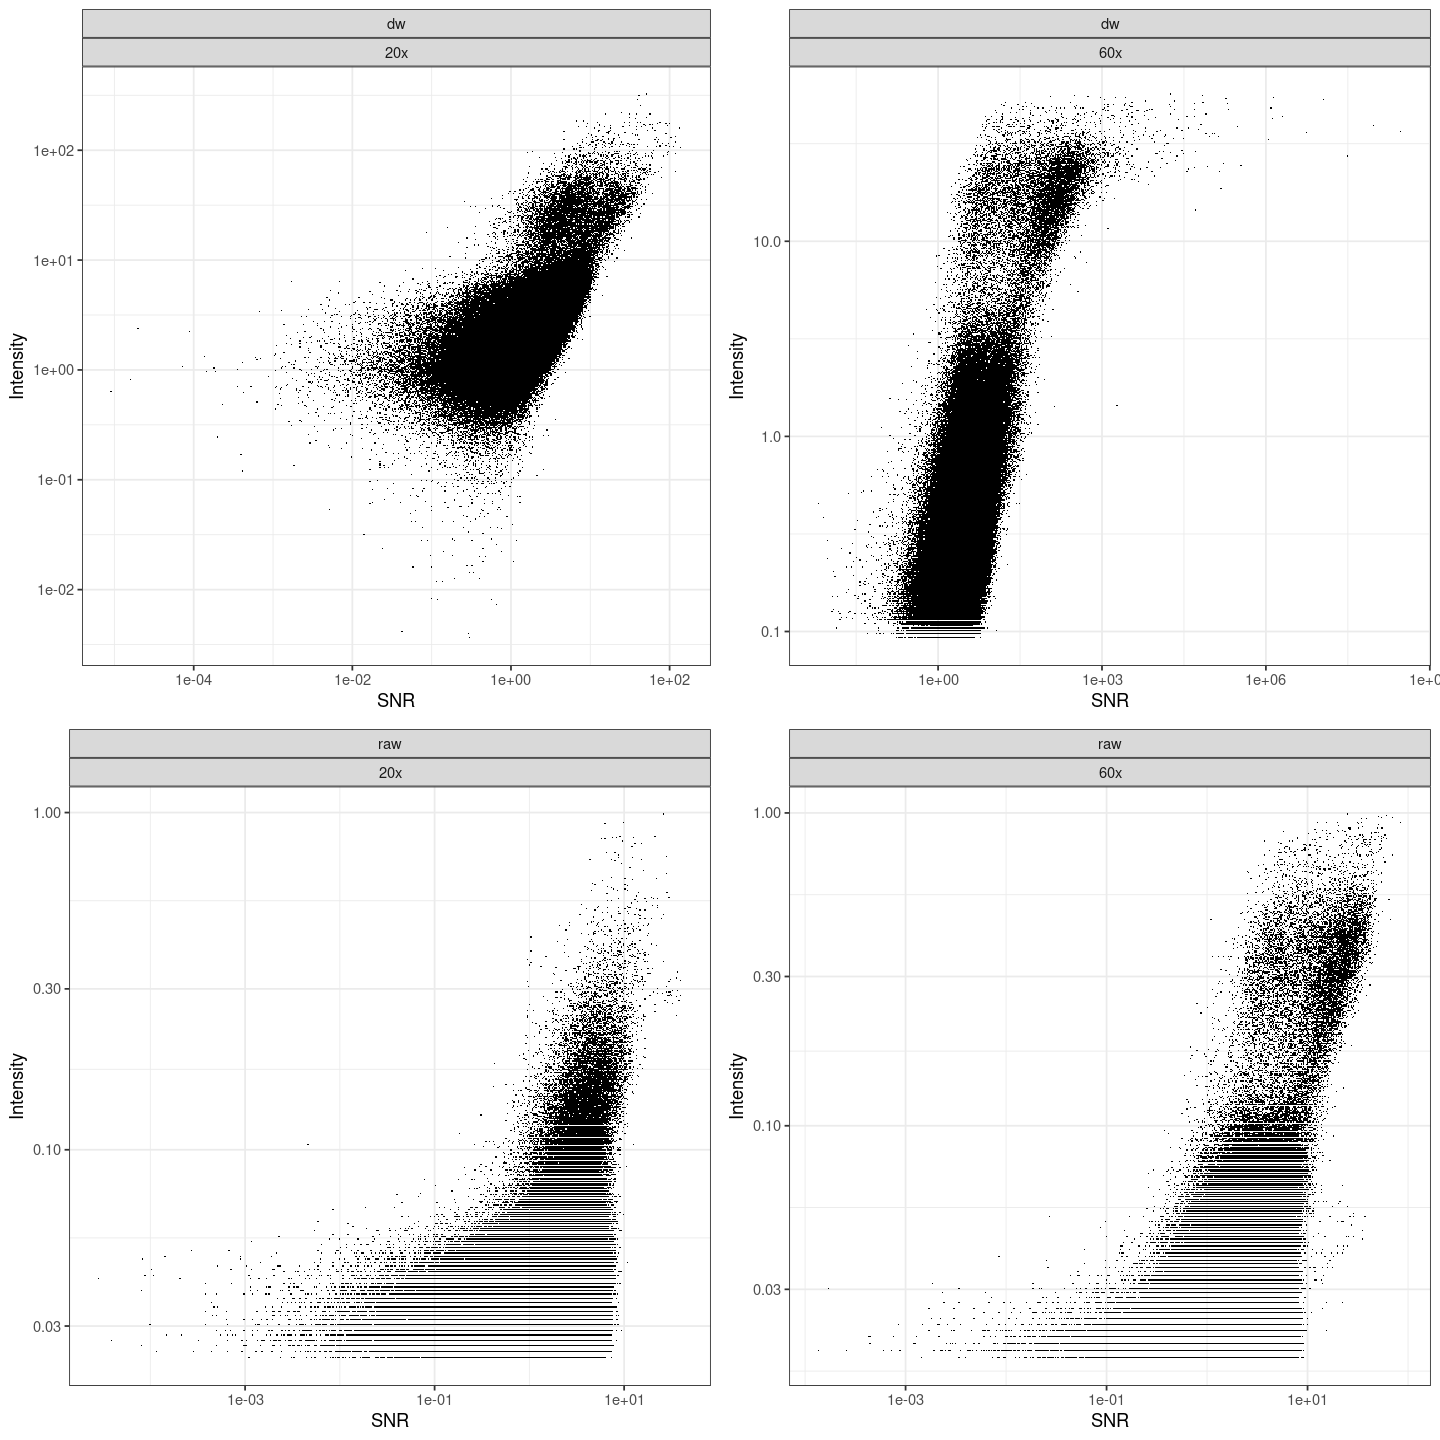

In [13]:
plist = pblapply(split(ddata, list(ddata$magnification, ddata$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            facet_wrap(~image_type~magnification, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=12, repr.plot.height=12)
plot_grid(plotlist=plist, nrow=2)

### After filtering for FWHM in [0.5; 5] and selecting only dots in (selected) nuclei

In [14]:
nuclear_features = fread("../../data/selected_nuclei.tsv", key=c("sid", "nid"))

In [15]:
ddata = dots_data2[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata2 = nuclear_features[ddata][!is.na(size)]

In [16]:
ddata2[, .N, by=c("magnification", "image_type")]

magnification,image_type,N
<chr>,<chr>,<int>
20x,dw,1363793
20x,raw,1845869
60x,dw,2030156
60x,raw,2437876


  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=15s  


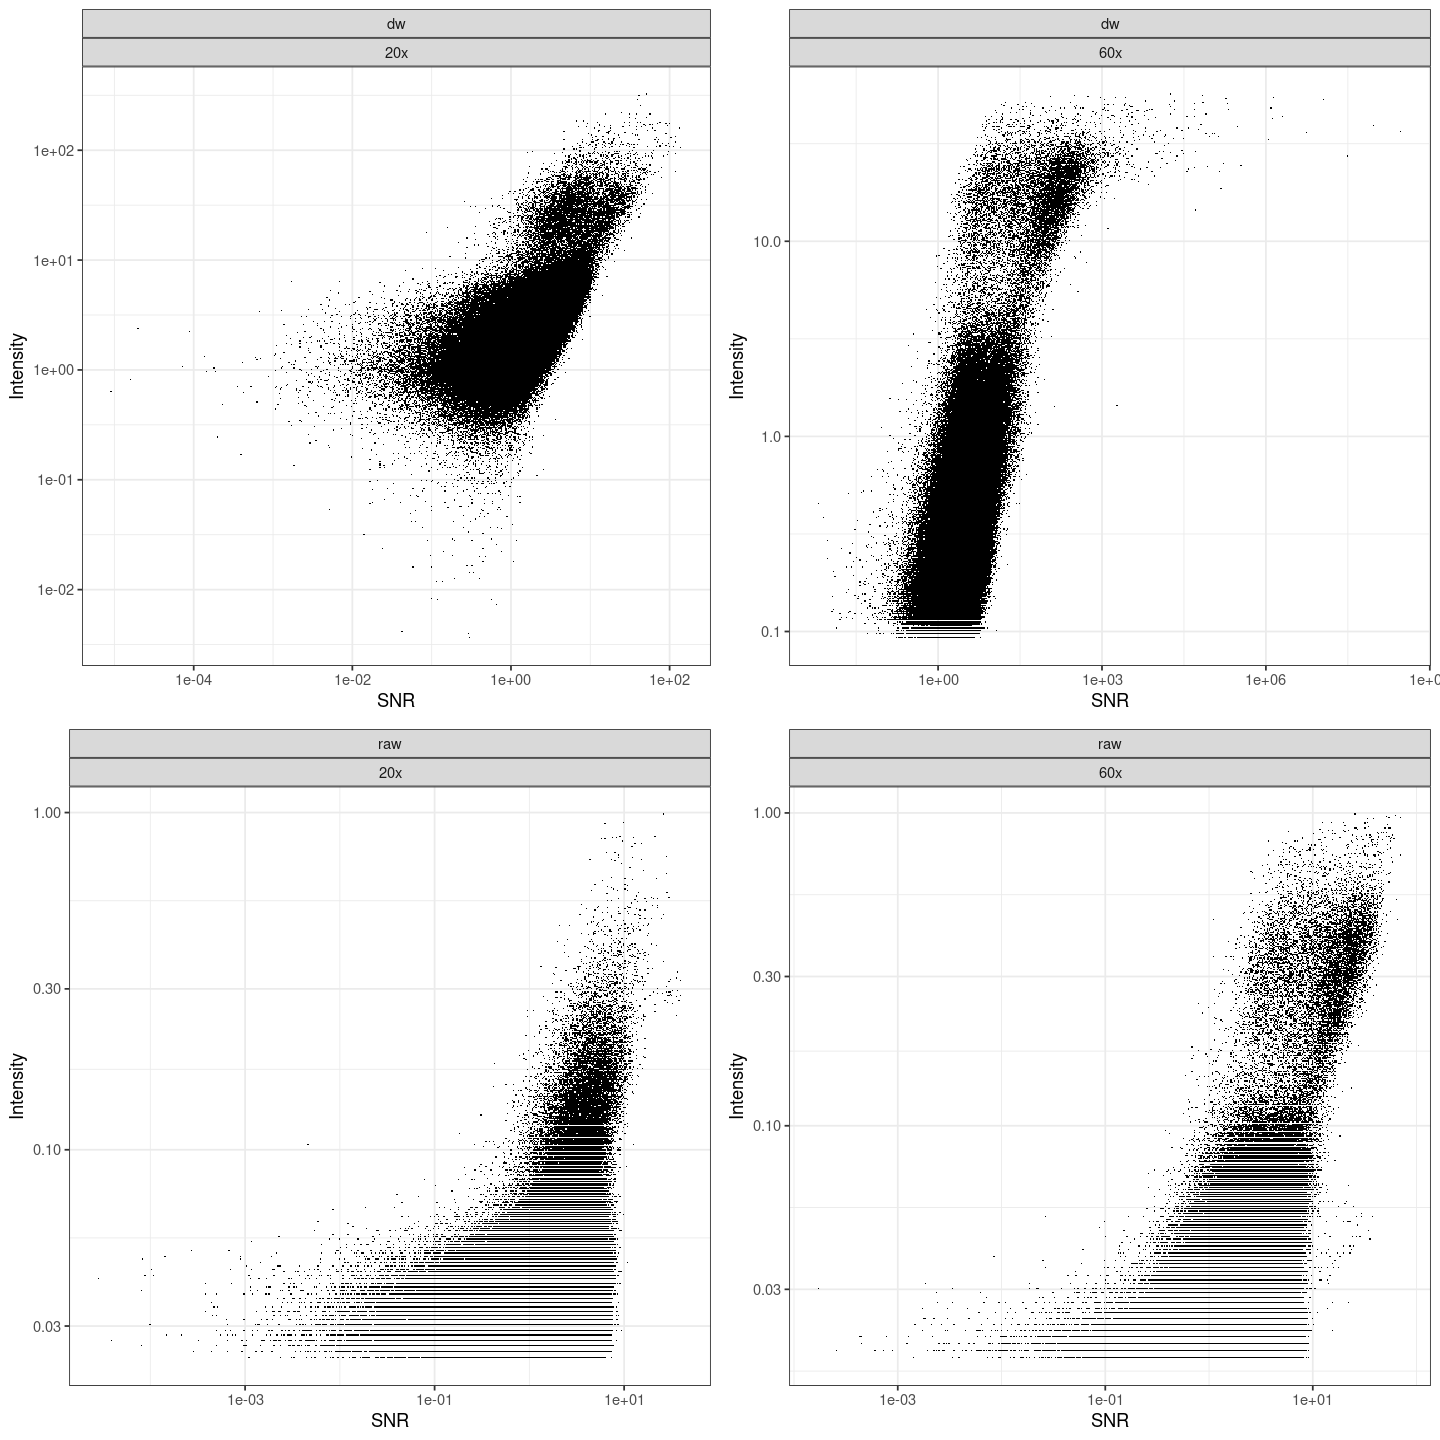

In [17]:
plist = pblapply(split(ddata2, list(ddata2$magnification, ddata2$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            facet_wrap(~image_type~magnification, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=12, repr.plot.height=12)
plot_grid(plotlist=plist, nrow=2)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=14s  


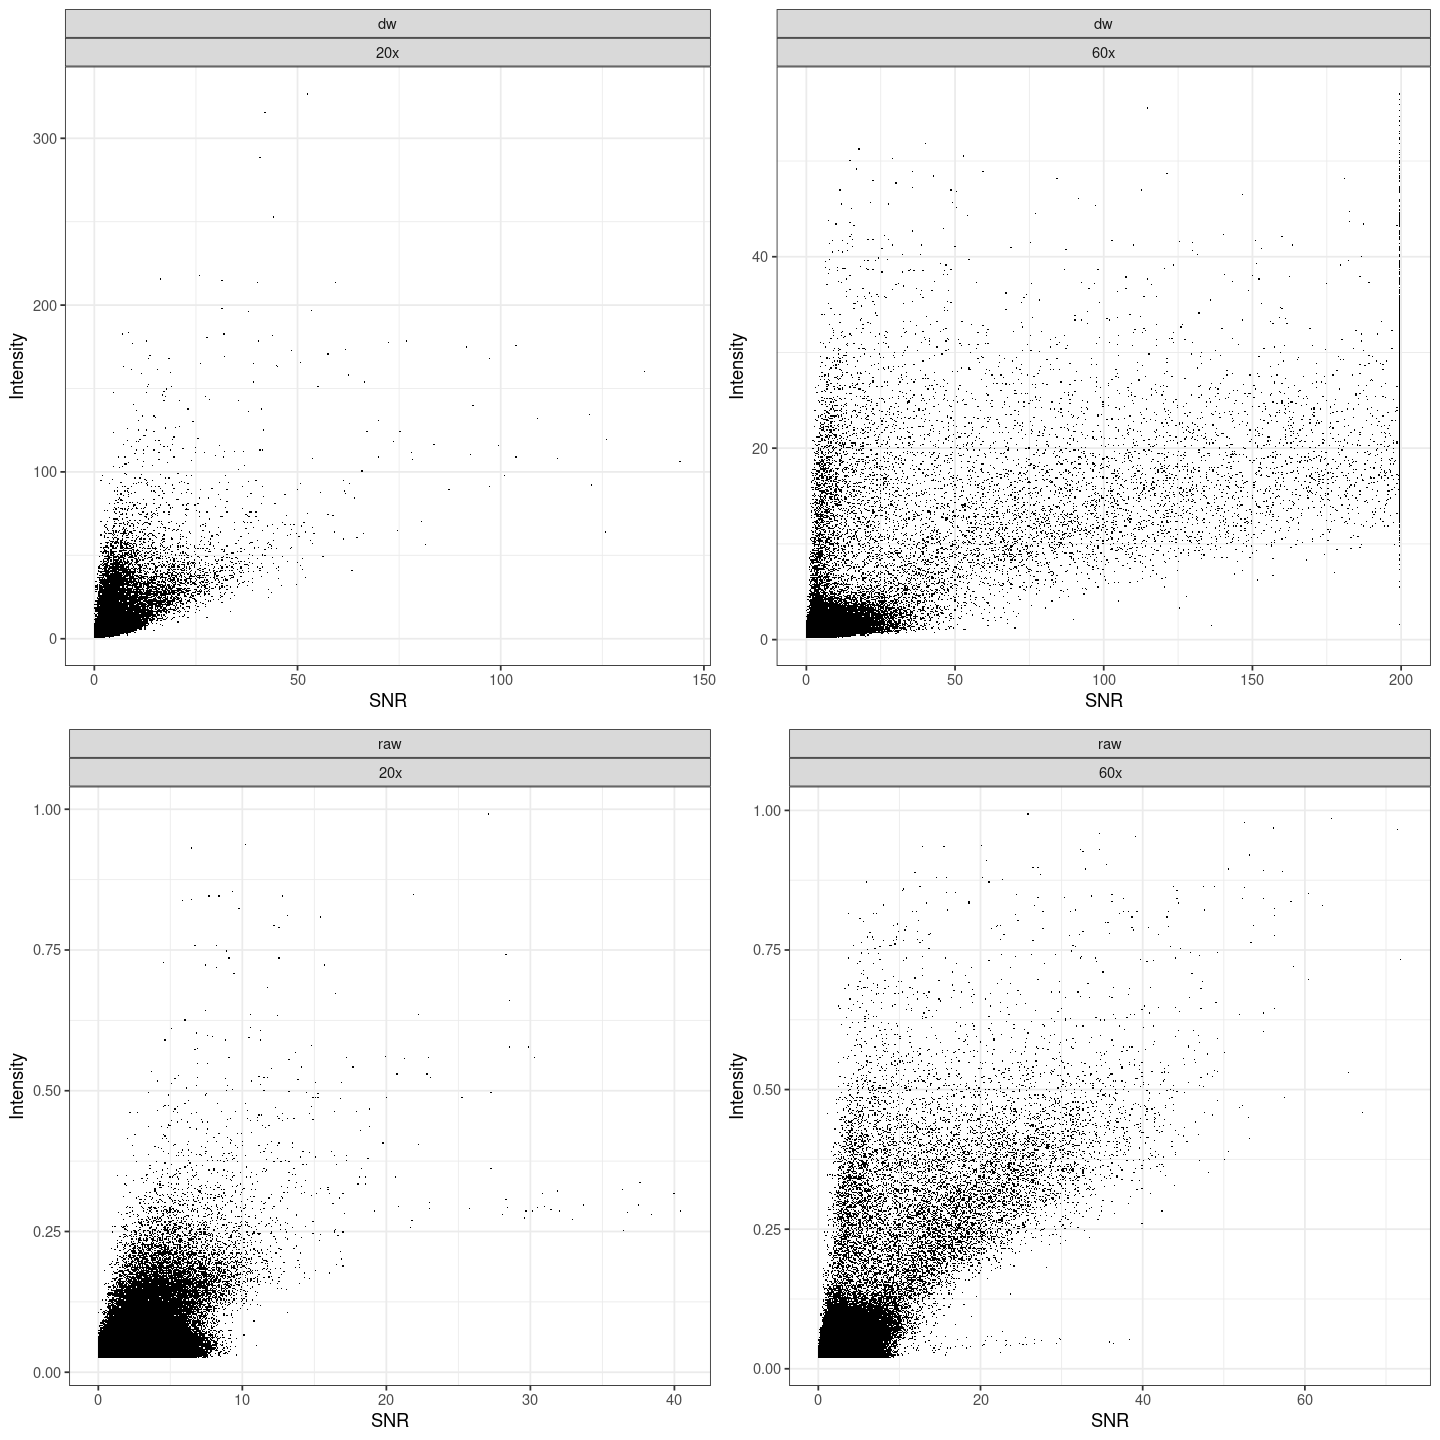

In [18]:
# Resetting SNR > 200 to 200, for visualization purposes (i.e., shifting outliers)
ddata3 = copy(ddata2)
ddata3[SNR2 > 200, SNR2 := 200]
plist = pblapply(split(ddata3, list(ddata3$magnification, ddata3$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            facet_wrap(~image_type~magnification, scales="free") + theme_bw() +
            labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=12, repr.plot.height=12)
plot_grid(plotlist=plist, nrow=2)

### Exporting dots after filtering for FWHM in [0.5; 5] and selecting only dots in (selected) nuclei

In [19]:
dim(dots_data)

[1] 27044770       17

In [20]:
dim(dots_data2)

[1] 26424544       17

In [21]:
dim(ddata2)

[1] 7677694      19

In [22]:
saveRDS(ddata2, file.path(root_path, "dots_data.clean.rds"))